In [4]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification  
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="whitegrid")

**1.1 Загрузка данных**

In [2]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:

X, y = make_classification(
    n_samples=30000,          
    n_features=23,            
    n_informative=15,         
    n_redundant=5,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=[0.78, 0.22],     
    flip_y=0.01,
    random_state=42
)


feature_names = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

df = pd.DataFrame(X, columns=feature_names)
df['default'] = y

print("Размер датасета:", df.shape)
df.head()

Размер датасета: (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,0.276920,1.293248,0.498577,-2.639403,-0.181126,3.096124,-0.909432,2.190866,-1.464635,1.801587,...,-4.993358,-2.332239,1.918261,-1.009671,4.349062,1.998965,1.230235,-0.271392,1.252572,1
1,-0.298394,-0.612445,3.484593,-0.774204,0.618414,2.897294,-1.130864,-1.967884,4.140024,3.555266,...,-5.927852,1.604800,-0.136775,-0.606208,-1.502206,-0.955602,0.912635,-3.604905,1.718248,0
2,-1.668142,-3.087847,1.638633,3.422592,-0.138331,1.771030,1.818696,-2.707569,3.359453,-0.272991,...,0.759540,2.084574,-2.663814,0.540558,1.916398,-1.905705,-10.461456,0.679594,1.084626,0
3,-0.145868,0.362914,0.955262,-1.383847,1.139185,-2.452105,1.724959,0.146116,-0.086517,-0.904689,...,1.547136,-1.892734,-0.004087,-0.939465,-3.630996,1.853215,1.484763,0.184474,1.550175,0
4,1.527289,-0.242891,-3.781412,6.557611,4.688017,1.049502,1.817853,1.668419,1.552960,-3.730465,...,-6.269644,-0.713174,-1.855925,0.789765,1.597035,5.569640,-11.172074,1.631436,1.502648,0


1.2. Анализ и очистка набора данных



In [6]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.231207,-0.020729,0.756917,0.001604,-0.755113,0.003786,0.547161,0.188589,-1.084470,-0.805700,...,1.051461,-0.227672,0.236498,-0.001624,-0.514807,-0.768316,-1.097442,-0.035324,-0.004480,0.222933
std,2.486000,2.377437,2.277997,2.207766,2.565434,2.492181,2.630876,2.183732,4.304922,2.206322,...,4.847720,2.198014,2.477393,1.002472,5.462629,2.371881,5.735844,2.452375,0.995441,0.416221
min,-9.289430,-11.939276,-9.743986,-8.476060,-10.636973,-10.230650,-9.155368,-8.490271,-20.288551,-10.235432,...,-20.426925,-9.165909,-10.422935,-3.856751,-20.075228,-10.378783,-29.954561,-10.192712,-3.920221,0.000000
25%,-1.486855,-1.591245,-0.738637,-1.552464,-2.466179,-1.668881,-1.285240,-1.241839,-3.951185,-2.296596,...,-2.066276,-1.720343,-1.451499,-0.684259,-4.253312,-2.336675,-4.795092,-1.675448,-0.670455,0.000000
50%,0.133829,0.013454,0.809311,-0.118257,-0.790273,0.002191,0.475257,0.264956,-1.117633,-0.820870,...,1.342509,-0.229634,0.230268,0.003813,-0.621276,-0.816578,-0.970495,-0.006847,-0.010918,0.000000
75%,1.855780,1.623192,2.270633,1.420602,0.919093,1.703411,2.283325,1.686593,1.788908,0.623795,...,4.398286,1.270134,1.918431,0.679586,3.113209,0.756836,2.723651,1.616958,0.663072,0.000000
max,10.786738,9.400286,10.116016,10.110256,10.683723,9.583872,11.078127,9.370853,17.775075,9.922207,...,19.805910,9.771923,11.284482,4.242657,26.951159,11.372056,27.145978,10.060752,4.048063,1.000000


**2.1 Формирование моделей**

In [ ]:

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42, eval_metric='logloss')
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)


estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('gb', gb)
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'Gradient Boosting': gb,
    'Stacking': stack
}


print("Созданные ансамблевые модели:\n")
for name, model in models.items():
    print(f"{name}:")
    print(f"   Класс: {model.__class__.__name__}")
    if name == 'Stacking':
        print(f"   Базовые модели: {', '.join([est[0] for est in estimators])}")
        print(f"   Мета-классификатор: {model.final_estimator.__class__.__name__}")
        print(f"   Кросс-валидация: {model.cv}-fold")
    else:
        print(f"   Основные параметры: {model.get_params(deep=False)}")
    print("-" * 50)

Созданные ансамблевые модели:

Random Forest:
   Класс: RandomForestClassifier
   Основные параметры: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
XGBoost:
   Класс: XGBClassifier
   Основные параметры: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 

**2.2. Формирование обучающей и тестирующей выборок**

In [8]:
# 2.2 Формирование выборок
X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Масштабирование (нужно для Stacking с LogisticRegression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")

Обучающая выборка: 24000 записей
Тестовая выборка: 6000 записей


2.3. Обучение моделей и предсказания



Обучение модели: Random Forest
Обучение модели: XGBoost
Обучение модели: Gradient Boosting
Обучение модели: Stacking


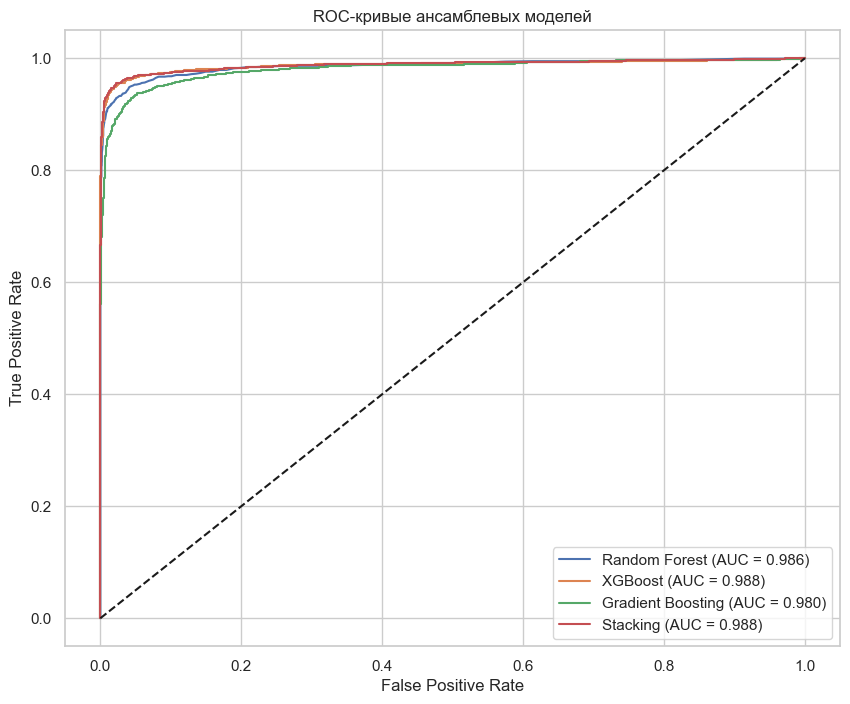

In [ ]:
# 2.3 Обучение и предсказания
predictions = {}

for name, model in models.items():
    print(f"Обучение модели: {name}")
    if name == 'Stacking':
        model.fit(X_train_scaled, y_train)
        pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        pred_proba = model.predict_proba(X_test)[:, 1]
        pred = model.predict(X_test)
    predictions[name] = (pred, pred_proba)

# ROC-кривые
plt.figure(figsize=(10, 8))
for name, (pred, proba) in predictions.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые ансамблевых моделей')
plt.legend()
plt.show()

3.1. Расчёт эффективности



Результаты моделей:


,Модель,Accuracy,Precision,Recall,F1-score,AUC
0,Random Forest,0.9635,0.9869,0.8475,0.9119,0.9860
1,XGBoost,0.9757,0.9693,0.9200,0.9440,0.9875
2,Gradient Boosting,0.9590,0.9635,0.8483,0.9022,0.9805
3,Stacking,0.9778,0.9660,0.9335,0.9494,0.9881


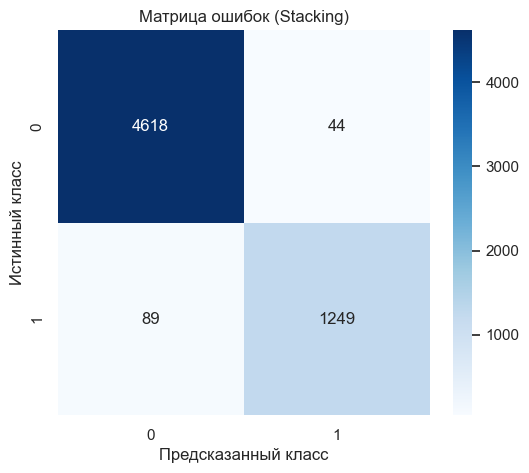

In [ ]:
# 3.1 Расчёт эффективности
results = []
for name, (pred, proba) in predictions.items():
    results.append({
        'Модель': name,
        'Accuracy': round(accuracy_score(y_test, pred), 4),
        'Precision': round(precision_score(y_test, pred), 4),
        'Recall': round(recall_score(y_test, pred), 4),
        'F1-score': round(f1_score(y_test, pred), 4),
        'AUC': round(roc_auc_score(y_test, proba), 4)
    })

results_df = pd.DataFrame(results)
print("Результаты моделей:")
display(results_df)

# Матрица ошибок для лучшей модели (обычно XGBoost или Stacking)
best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Модель']
cm = confusion_matrix(y_test, predictions[best_model_name][0])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Матрица ошибок ({best_model_name})')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

3.2. Оптимизация моделей



In [ ]:
# 3.2 Оптимизация (пример для XGBoost)
print("Оптимизация XGBoost через GridSearchCV...")

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1]
}

grid = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший AUC на CV:", round(grid.best_score_, 4))

# Финальная модель
best_xgb = grid.best_estimator_
final_proba = best_xgb.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, final_proba)
print(f"Финальный AUC оптимизированной модели: {final_auc:.4f}")

Оптимизация XGBoost через GridSearchCV...
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Лучший AUC на CV: 0.9883
Финальный AUC оптимизированной модели: 0.9877
